In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
from jax.scipy.stats import norm

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.gaussian import IsotropicGauss
from mcjax.mcmc.rwm import Rwm
# from mcjax.util.mcmc import ESS_geyer, normalized_autocorr



In [2]:
# initialize jax RNG
key = jr.key(0)

In [3]:
def run_rwm_experiment(key, dim, step_size, n_steps):
    # Define log-density
    mu = jnp.full(dim, 1.)
    log_var = jnp.log(2.)
    dist = IsotropicGauss(mu=mu, log_var=log_var)
    logdensity = dist.logdensity

    # Initialize RWM
    rwm = Rwm(logdensity=logdensity, step_size=step_size, cov=jnp.eye(dim))
    x0 = jnp.zeros(dim)
    state_init = rwm.init_state(x0)

    # Run sampler
    key, subkey = jr.split(key)
    output = rwm.run(key=subkey, n_samples=n_steps, state_init=state_init)
    return output.summary.acceptance_rate

# Define dimensions and step size strategies
dim_arr = jnp.arange(1, 101, 10)
n_steps = 100_000

acc_rate_arr1 = []
acc_rate_arr2 = []
acc_rate_arr3 = []

for dim in dim_arr:
    print(f"Running RWM for dim={dim}")
    key, subkey1, subkey2, subkey3 = jr.split(key, 4)
    acc_rate_arr1.append(run_rwm_experiment(subkey1, dim, 0.1 / jnp.sqrt(dim), n_steps))
    acc_rate_arr2.append(run_rwm_experiment(subkey2, dim, 0.1 / dim, n_steps))
    acc_rate_arr3.append(run_rwm_experiment(subkey3, dim, 0.1, n_steps))

Running RWM for dim=1
Running RWM for dim=11
Running RWM for dim=21
Running RWM for dim=31
Running RWM for dim=41
Running RWM for dim=51
Running RWM for dim=61
Running RWM for dim=71
Running RWM for dim=81
Running RWM for dim=91


Text(0.5, 1.0, 'Acceptance rate // step size')

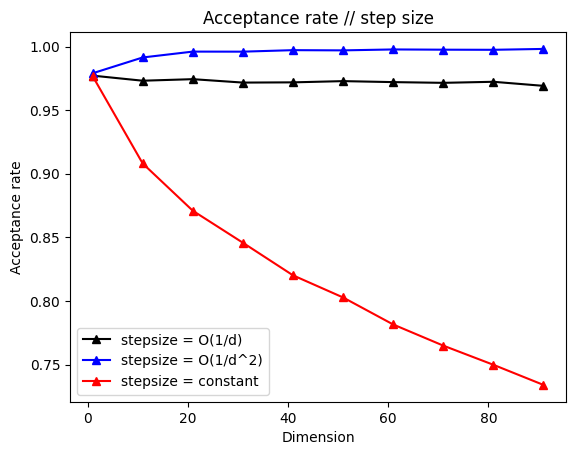

In [9]:
plt.plot(dim_arr,acc_rate_arr1, "k-^", label="stepsize = O(1/d)")
plt.plot(dim_arr,acc_rate_arr2, "b-^", label="stepsize = O(1/d^2)")
plt.plot(dim_arr,acc_rate_arr3, "r-^", label="stepsize = constant")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate // step size")


In [12]:
# fix step sigma^2 O(1/d), analysis Square jump distance / acceptance rate
dim_arr = jnp.arange(1, 101, 10)
ratio_arr = []
ell = 0.1
for dim in dim_arr:
    print(f"Running RWM for dim={dim}")
    # Target distribution
    mu = jnp.full(dim,1.)
    log_var = jnp.log(2)
    dist = IsotropicGauss(mu=mu, log_var=log_var)
    logdensity = dist.logdensity
    # random walk metropolis
    mcmc = Rwm(logdensity=logdensity, step_size=ell/dim**(1/2), cov=jnp.eye(dim))
    
    # sample the trajectory with step size o(1/d)
    key, key_ = jr.split(key)
    x0 = jnp.zeros((dim,))
    n_steps = 100_000
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    traj = mcmc_output.traj
    summary = mcmc_output.summary
    ratio_arr.append(summary.sq_jump/summary.acceptance_rate)


Running RWM for dim=1
Running RWM for dim=11
Running RWM for dim=21
Running RWM for dim=31
Running RWM for dim=41
Running RWM for dim=51
Running RWM for dim=61
Running RWM for dim=71
Running RWM for dim=81
Running RWM for dim=91


Text(0.5, 1.0, 'Ratio of Square jump distance / acceptance rate over dimension')

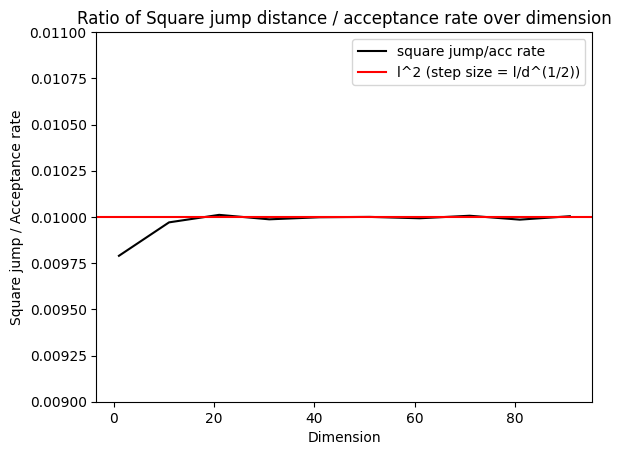

In [13]:
plt.plot(dim_arr,ratio_arr,label = "square jump/acc rate",color="black")
plt.axhline(y=ell**2,label="l^2 (step size = l/d^(1/2))",color = "red")
plt.xlabel("Dimension")
plt.ylabel("Square jump / Acceptance rate")
plt.legend()
eps_jitter = 1e-3
plt.ylim(ell**2 - eps_jitter, ell**2 + eps_jitter)
plt.title("Ratio of Square jump distance / acceptance rate over dimension")

In [14]:
# Efficiency and Acceptance rate
# Set a higher dimension (dim = 20)
dim = 20
# Target distribution
mu = jnp.full(dim,1.)
log_var = jnp.log(2)
dist = IsotropicGauss(mu=mu,log_var=log_var)
logdensity = dist.logdensity

In [15]:
def sample_RWM(key, x0, step_size, n_steps, dim):
    # define the RWM sampler
    mcmc = Rwm(logdensity=logdensity, step_size=step_size/dim**(1/2), cov=jnp.eye(dim))
    # sample the trajectory
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    return mcmc_output

sample_RWM = jax.jit(sample_RWM, static_argnums=(3,4))
sample_RWM_batch = jax.vmap(sample_RWM, in_axes=(0, None, 0, None, None))
sample_RWM_batch = jax.jit(sample_RWM_batch, static_argnums=(3,4))


In [16]:
step_size_arr = np.linspace(0.01, 5., 500)
n_steps = 100_000
keys = jax.random.split(jax.random.PRNGKey(0), len(step_size_arr) + 1)
keys, key_ = keys[:-1], keys[-1]
x0 = jnp.zeros((dim,))
mcmc_output_batch = sample_RWM_batch(keys, x0, step_size_arr, n_steps,dim)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary

Text(0.5, 1.0, 'Efficiency v.s. Acc rate')

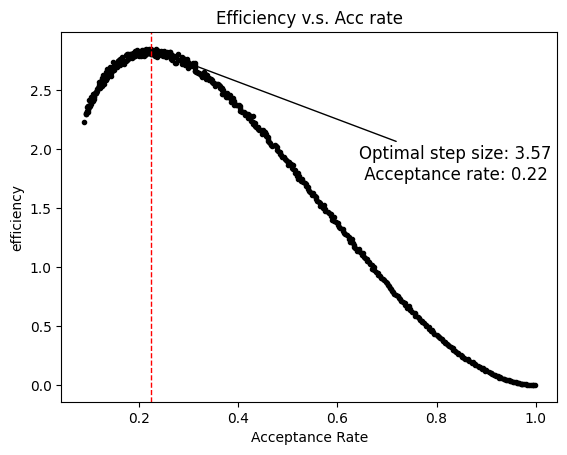

In [18]:
efficiency = [summary_batch.acceptance_rate[i]*step_size_arr[i]**2 for i in range(len(step_size_arr))]
plt.plot(summary_batch.acceptance_rate, efficiency, ".", color='black')
# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(efficiency)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, efficiency[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.xlabel("Acceptance Rate")
plt.ylabel("efficiency")
plt.title("Efficiency v.s. Acc rate")